This builds on TESQ-ml-ns-nogo-go

> **proposal 1**
> 
> Two class (e.g., CorrectStop vs. CorrectGo)
> 
> Leave-One-Out classifier...
> 
> Neural similarity of a subject to the group with a Stop vs. Go contrast might actually be indicative of performance.
> 
> subjects will naturally differ across the task as to how much their average signal responds to that, and the ones with better response might have better response inhibition.

We use the same neural data, but instead of regressing on classifying these classes, we take one class or the other or we combine them in some way and we regress on our self report variables.

So there are a couple of steps here...

1. iterate through subjects, holding out one at a time, and do the following steps.
2. Train a regressor across all the training subjects, regressing CorrectStop and CorrectGo on TESQ-E and other self report measures including FFQ either (a) independently (b) contrasted with each other (c) concatenated in a single image.
3. If a link can be established, we've shown there is a relevant link between TESQ-E or other self-report measure, and the neural signature.
4. ...that seems like a publication in itself!




As a first pass, we can simplify this a bit just trying that single classifier on all subjects. This means that we're using train for tes tset but it will give us an initial measure of feasibility.

We probably do need to restrict to a specific brain region though, and that means retraining. - I think that prefrontal cortex mask we have works well.

## Data already generated

Can we use data already generated in `SST_inhibition_cv.ipynb`?

In [1]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_21688/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [2]:
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [3]:
#results_filepath=ml_data_folderpath + "/SST/train_test_results_conditions_40subs_twoclasses.pkl"

In [4]:
#results_2c = pickle.load(open(results_filepath,'rb'))

Not quite--we need a PFC mask I think. But we can use the script already written to do that.

## Setup

In [5]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

#from apply_loocv_and_save import *
#from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



In [6]:
from sklearn.svm import LinearSVC
from scipy.stats import ttest_1samp, pearsonr

In [7]:
from pymvpa2_ml_library import *
from generic_utils import *

In [8]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [9]:
#from analyze_results import *

## condition_contrast

## stitching contrasts together in different ways

We'd want:

 - contrast of the two conditions
 - each of the two conditions alone.
 
The contrast is a little tricky. Easiest thing is to try each of the conditions alone. Stitching the two together might not be too hard. Let's try doing CorrectStop first, and then we'll try concatenating the images. Doing a contrast is actually the most difficult becuase I have to backtrack in the process to generate new betas (see https://docs.google.com/presentation/d/1K-nFrZYE6rR8t0myNyacB7frBzV3B1--nMqPhVkwL8E/edit#slide=id.geeff6890fb_0_16).

See `different ways of combining images.ipynb`.

## template

## regressing on self report

In [12]:
nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s



In [13]:

## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [14]:
print(all_masks)

                                            mask_name  \
0         negative affect_association-test_z_FDR_0.01   
1     response inhibition_association-test_z_FDR_0.01   
2       negative emotions_association-test_z_FDR_0.01   
0   harvardoxford-cortical_prob_Superior Frontal G...   
1            harvardoxford-cortical_prob_Frontal Pole   
2   harvardoxford-cortical_prob_Cingulate Gyrus, p...   
3   harvardoxford-cortical_prob_Frontal Orbital Co...   
4   harvardoxford-cortical_prob_Frontal Operculum ...   
5   harvardoxford-cortical_prob_Supramarginal Gyru...   
6           harvardoxford-cortical_prob_Angular Gyrus   
7   harvardoxford-cortical_prob_Cingulate Gyrus, a...   
8   harvardoxford-cortical_prob_Lateral Occipital ...   
9   harvardoxford-cortical_prob_Inferior Frontal G...   
10  harvardoxford-cortical_prob_Inferior Frontal G...   
11         harvardoxford-cortical_prob_Insular Cortex   

                                        mask_filepath  thresh  
0   /gpfs/projects/sanl

In [70]:
def setup_metadata(bd,target_val):
    #set up chunks and targets so we can do the learning.
    attribute_df = sa_to_df(bd.sa)
    pd.concat([attribute_df['subject'],attribute_df['wave']],axis=1)
    chunk = attribute_df['subject']+"_" + attribute_df['wave'].astype(str)
    Brain_Data_allsubs.sa['chunks'] = list(chunk)
    target_data = bd.sa[target_val].value
    target_data_mean = np.nanmean(target_data)
    target_data_std = np.nanstd(target_data)
    target_data_norm = (bd.targets-target_data_mean)/target_data_std
    Brain_Data_allsubs.sa['targets'] = list(target_data_norm)
    return(Brain_Data_allsubs)

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import *
from sklearn.linear_model import *

def do_Ridge(train_X,train_y,test_X,test_y):
    sklearn_regress = Ridge(alpha=5.0)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
    return(predict_y,sklearn_regress)
    


## whole-brain

In [14]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [15]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [16]:
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'TESQ_E_sum')

In [17]:
Brain_Data_CorrectStop = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectStop']

In [18]:
from mvpa2.measures.rsa import Regression
from sklearn.linear_model import Ridge

In [52]:
regression_results = do_regression(Brain_Data_allsubs)

eliminating 12 of 162 items due to null input values.
...........................................................................

In [53]:
from sklearn.svm import LinearSVC
from scipy.stats import ttest_1samp, pearsonr

In [54]:
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

(-0.16045875168791282, 0.04982079777134878)

That's pretty good considering that we are regressing over all images whether they're Stop or Go signal. need to change this so that we alternately regress over stop or go only, or possibly, the difference between them.

The contrast between them is probably best, which means we go to generate a new series based on that.

Though, wait--why is it _negative_?

In [55]:
regression_results_CS = do_regression(Brain_Data_CorrectStop)
pearsonr(regression_results_CS['sample_wise']['target_y'],regression_results_CS['sample_wise']['pred_y'])

eliminating 6 of 81 items due to null input values.
...........................................................................

(-0.2239527012000021, 0.0534184925663768)

In [76]:
regression_results_CS['sample_wise']

,chunks,target_y,pred_y
0,DEV005_1,50.0,58.404549
0,DEV006_1,69.0,58.419716
0,DEV010_1,45.0,51.032341
0,DEV011_1,38.0,53.185638
0,DEV013_1,54.0,55.428978
...,...,...,...
0,DEV197_1,60.0,54.939503
0,DEV206_1,48.0,50.780682
0,DEV215_1,44.0,56.035248
0,DEV216_1,41.0,59.943550


In [61]:
from matplotlib.pyplot import scatter

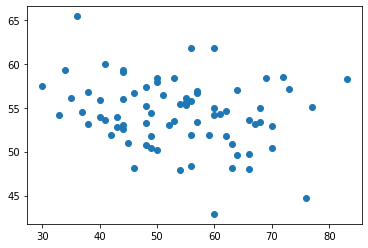

In [62]:
scatter(regression_results_CS['sample_wise']['target_y'],regression_results_CS['sample_wise']['pred_y'])

And really odd--why does it perform equally well for one class as for two? I thought two class analysis would be really nonsensical...which it is...considering the negative correlation for targets vs. pred

In [57]:
Brain_Data_CorrectGo = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectGo']
regression_results_CG = do_regression(Brain_Data_CorrectGo)
pearsonr(regression_results_CG['sample_wise']['target_y'],regression_results_CG['sample_wise']['pred_y'])

eliminating 6 of 81 items due to null input values.
...........................................................................

(-0.028789840475960636, 0.8063089701891368)

## try lasso

In [64]:
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso)

eliminating 12 of 162 items due to null input values.
...........................................................................

In [65]:
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

(-0.05887433981617397, 0.4742077699655372)

Very very different, and honestly a bit frightening one gets such a different result from a very similar method?

## stop minus go contrast

In [115]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_cor_stop_minus_go_contrast.pkl'
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'TESQ_E_sum')

In [116]:
regression_results = do_regression(Brain_Data_allsubs)
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

eliminating 6 of 81 items due to null input values.
...........................................................................

(0.038879700486351594, 0.7405100290028542)

## Trial dummy data

We select a linear mix of voxels and try to predict that. should be easy to do with regression...

In [28]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'
#mvpa_Dataset_conditions_84subs_cor_stop_minus_go_contrast

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [29]:
mix_target = np.sum(Brain_Data_allsubs.samples[:,15000:15010],axis=1)
Brain_Data_allsubs.sa['mix_target']=list(mix_target)

In [30]:

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'mix_target')

regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Ridge)

pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

eliminating 0 of 162 items due to null input values.
.................................................................................

(0.28250428762113333, 0.00027018352457396484)

That's interesting--something like it should be, but not very good considering.

In [31]:
mix_target = np.sum(Brain_Data_allsubs.samples[:,15000:15100],axis=1)
Brain_Data_allsubs.sa['mix_target']=list(mix_target)
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'mix_target')
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Ridge)
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

eliminating 0 of 162 items due to null input values.
.................................................................................

(0.8000696765345883, 2.443531180731693e-37)

aahhh got it--if the pattern is spread over several voxels, we'll have a better time detecting it.

In [109]:
mix_target = np.sum(Brain_Data_allsubs.samples[:,15000:15100],axis=1)
Brain_Data_allsubs.sa['mix_target']=list(mix_target)

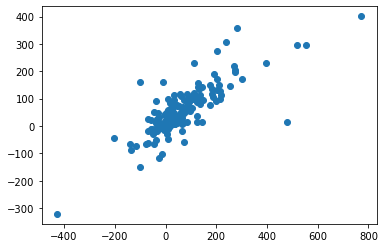

In [111]:
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

OK, so if there's a pattern representing a linear combination of voxels then we should be able to detect it using ridge regression. How about lasso?

eliminating 0 of 162 items due to null input values.
.................................................................................(0.907475656018222, 3.7843850534794656e-62)


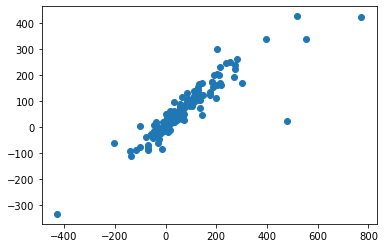

In [46]:
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso)
print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [43]:
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

(0.8000696765345883, 2.443531180731693e-37)

So in summary--we can't predict TESQ-E-Sum using Ridge or Lasso regression. Because prediction is `greedy' in a sense--it'll take voxels anywhere in the image and emphasize them until they're useful--there's no point in trying different masks. We might try different scales, bu there's no use in doing a regression on masks.

#### Elastic net?

In [39]:
from sklearn.linear_model import ElasticNet
def do_ElasticNet(train_X,train_y,test_X,test_y):
    sklearn_regress = ElasticNet(alpha=10.0)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
    return(predict_y,sklearn_regress)

In [40]:

elastic_regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_ElasticNet)


eliminating 0 of 162 items due to null input values.
..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e+03, tolerance: 2.702e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.571e+03, tolerance: 2.713e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e+03, tolerance: 2.735e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e+03, tolerance: 2.737e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e+03, tolerance: 2.745e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e+03, tolerance: 2.729e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e+03, tolerance: 2.748e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e+03, tolerance: 2.748e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e+03, tolerance: 2.738e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e+03, tolerance: 2.718e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.272e+03, tolerance: 2.572e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e+03, tolerance: 2.748e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e+03, tolerance: 2.749e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e+03, tolerance: 2.745e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.663e+03, tolerance: 2.705e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e+03, tolerance: 2.744e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e+03, tolerance: 2.749e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e+03, tolerance: 2.741e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.539e+03, tolerance: 2.729e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e+03, tolerance: 2.739e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e+03, tolerance: 2.492e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e+03, tolerance: 2.717e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e+03, tolerance: 2.726e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+03, tolerance: 2.529e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e+03, tolerance: 2.738e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+03, tolerance: 2.743e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+03, tolerance: 2.727e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e+03, tolerance: 2.749e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+03, tolerance: 2.723e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e+03, tolerance: 2.735e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+03, tolerance: 2.469e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e+03, tolerance: 2.635e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+03, tolerance: 2.726e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e+03, tolerance: 2.716e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e+03, tolerance: 2.736e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e+03, tolerance: 2.738e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e+03, tolerance: 2.733e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e+03, tolerance: 2.735e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+03, tolerance: 2.705e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e+03, tolerance: 2.730e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+03, tolerance: 2.737e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+03, tolerance: 2.744e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e+03, tolerance: 2.741e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e+03, tolerance: 2.742e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e+03, tolerance: 2.735e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+03, tolerance: 2.727e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+03, tolerance: 2.749e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e+03, tolerance: 2.735e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+03, tolerance: 2.728e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+03, tolerance: 2.726e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e+03, tolerance: 2.748e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e+03, tolerance: 2.747e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e+03, tolerance: 2.726e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e+03, tolerance: 2.724e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+03, tolerance: 2.736e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e+03, tolerance: 2.703e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e+03, tolerance: 2.733e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e+03, tolerance: 2.726e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e+03, tolerance: 2.697e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.189e+03, tolerance: 2.191e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+03, tolerance: 2.745e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e+03, tolerance: 2.744e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e+03, tolerance: 2.748e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+03, tolerance: 2.696e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+03, tolerance: 2.747e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e+03, tolerance: 2.742e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+03, tolerance: 2.743e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e+03, tolerance: 2.745e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+03, tolerance: 2.734e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e+03, tolerance: 2.713e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e+03, tolerance: 2.674e+02
  model = cd_fast.enet_coordinate_descent(


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e+03, tolerance: 2.743e+02
  model = cd_fast.enet_coordinate_descent(
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e+03, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

(0.878319374933286, 3.7499713555839137e-53)

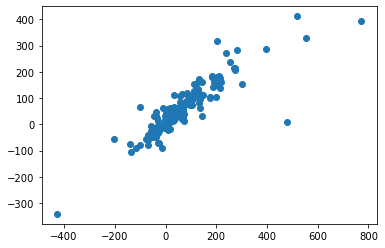

In [42]:

scatter(elastic_regression_results['sample_wise']['target_y'],elastic_regression_results['sample_wise']['pred_y'])
pearsonr(elastic_regression_results['sample_wise']['target_y'],elastic_regression_results['sample_wise']['pred_y'])

OK, of the three (Ridge, Elastic, Lasso), Lasso performs best on the dummy data, so we'll use that.

## PCA?

## odd anti-correlated pattern--need to investigate this!

In [18]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

In [67]:
abs(-4)

4

In [68]:
def do_regression(dataset,normalization=None,get_prediction=None,verbose=False):
    if get_prediction is None:
        get_prediction = do_Ridge
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []

    items_to_eliminate_count = np.sum(np.isnan(dataset.sa.targets))
    items_total = len(dataset.sa.targets)
    print("eliminating " + str(items_to_eliminate_count) + " of " + 
          str(items_total) + " items due to null input values.")
    
    dataset=dataset[np.isnan(dataset.sa.targets)==False]
    
    #ensure data is normalized
    if abs(np.nanmean(dataset.sa.targets)>0.001):
        raise Exception("target data is not mean-centred, but mean centering is required.")

    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
#         print(train_y)
#         print(test_y)
        predict_y, sklearn_clf = get_prediction(train_X,train_y,test_X,test_y)
        
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
        })
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, model_final =get_prediction(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,#'group_wise':group_scores,
            'model':model_final})


In [71]:
regression_results_dict = {}
for regression_var in [
    'TESQ_E_distraction',
    'TESQ_E_goal_deliberation'
    #,
#     'TESQ_E_sum', 'TESQ_E_avoidance_of_temptations',
#                        'TESQ_E_goal_deliberation',
#                        'TESQ_E_goal_and_rule_setting','TESQ_E_suppression',
#                        'bf_1','SST_SSRT'
                      ]:
    print(regression_var)
    Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,regression_var)
    regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso)
    regression_results_dict[regression_var] = regression_results
    print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
    print("---")

TESQ_E_distraction


ValueError: Collectable 'targets' with length [81] does not match the required length [162] of collection '<SampleAttributesCollection: ACES_abuse,ACES_divorced_separated,ACES_household_dysfunction,ACES_neglectful_parenting,ACES_sum,BFI_agreeableness,BFI_conscientiousness,BFI_extraversion,BFI_neurotici...>'.

Is it entirely limited to trying to predict CorrectSTop and CorrectGo simultaneously, in which they consistently have the same output var?

If they do, then it _must_ optimize on features that _are_ related to TESQ-E but have _nothing_ to do with differences between correct stop and correct go.

But it's doing one worse than that, it's somehow optimizing on the opposite, and underperforming.

### CorrectStop only

In [25]:
Brain_Data_CorrectStop = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectStop']

In [29]:
from sklearn.linear_model import Lasso
def do_Lasso(train_X,train_y,test_X,test_y):
    sklearn_regress = Lasso(alpha=5.0)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
    print(predict_y,test_y,end=", ")
    return(predict_y,sklearn_regress)

In [30]:
regression_results_dict = {}
for regression_var in [
    'TESQ_E_distraction',
    'TESQ_E_goal_deliberation'
    #,
#     'TESQ_E_sum', 'TESQ_E_avoidance_of_temptations',
#                        'TESQ_E_goal_deliberation',
#                        'TESQ_E_goal_and_rule_setting','TESQ_E_suppression',
#                        'bf_1','SST_SSRT'
                      ]:
    print(regression_var)
    Brain_Data_CorrectStop = setup_metadata(Brain_Data_CorrectStop,regression_var)
    regression_results = do_regression(Brain_Data_CorrectStop, get_prediction = do_Lasso)
    regression_results_dict[regression_var] = regression_results
    print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
    print("---")

TESQ_E_distraction
eliminating 6 of 81 items due to null input values.
.[8.040541] [8.], .[8.] [11.], .[8.054054] [7.], .[8.081081] [5.], .[8.040541] [8.], .[7.9864864] [12.], .[8.054054] [7.], .[8.040541] [8.], .[8.067568] [6.], .[8.040541] [8.], .[8.081081] [5.], .[7.972973] [13.], .[8.027027] [9.], .[7.972973] [13.], .[8.081081] [5.], .[8.054054] [7.], .[8.054054] [7.], .[8.013514] [10.], .[8.067568] [6.], .[8.067568] [6.], .[7.9459457] [15.], .[8.] [11.], .[8.081081] [5.], .[8.081081] [5.], .[8.054054] [7.], .[7.9594593] [14.], .[8.054054] [7.], .[8.054054] [7.], .[8.054054] [7.], .[8.081081] [5.], .[8.054054] [7.], .[8.067568] [6.], .[8.081081] [5.], .[8.054054] [7.], .[8.027027] [9.], .[7.972973] [13.], .[8.040541] [8.], .[8.040541] [8.], .[8.040541] [8.], .[8.054054] [7.], .[8.040541] [8.], .[8.040541] [8.], .[8.] [11.], .[8.067568] [6.], .[8.054054] [7.], .[8.] [11.], .[8.054054] [7.], .[7.9864864] [12.], .[8.067568] [6.], .[8.081081] [5.], .[8.027027] [9.], .[8.067568] [6.], .

In [31]:
regression_results_dict['TESQ_E_distraction']

{'sample_wise':       chunks  target_y    pred_y
 0   DEV005_1       8.0  8.040541
 0   DEV006_1      11.0  8.000000
 0   DEV010_1       7.0  8.054054
 0   DEV011_1       5.0  8.081081
 0   DEV013_1       8.0  8.040541
 ..       ...       ...       ...
 0   DEV197_1      10.0  8.013514
 0   DEV206_1       4.0  8.094595
 0   DEV215_1       6.0  8.067568
 0   DEV216_1       7.0  8.054054
 0   DEV217_1       8.0  8.040541
 
 [75 rows x 3 columns],
 'model': Lasso(alpha=5.0)}

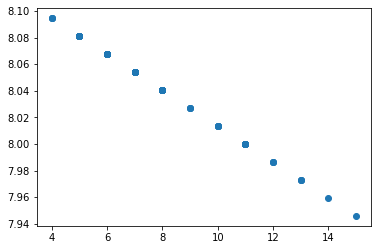

In [32]:
from matplotlib.pyplot import scatter
rr = regression_results_dict['TESQ_E_distraction']
scatter(rr['sample_wise']['target_y'],rr['sample_wise']['pred_y'])

really odd!! Has the CorrectStop X integrated Y somehow?

In [40]:
sa_to_df(Brain_Data_CorrectStop.sa)[['targets','TESQ_E_goal_deliberation']]

,targets,TESQ_E_goal_deliberation
1,6.0,6.0
3,11.0,11.0
5,6.0,6.0
7,6.0,6.0
9,11.0,11.0
...,...,...
153,9.0,9.0
155,8.0,8.0
157,6.0,6.0
159,8.0,8.0


In [45]:
dataset= Brain_Data_CorrectStop
items_to_eliminate_count = np.sum(np.isnan(dataset.sa.targets))
items_total = len(dataset.sa.targets)
print("eliminating " + str(items_to_eliminate_count) + " of " + 
      str(items_total) + " items due to null input values.")

dataset=dataset[np.isnan(dataset.sa.targets)==False]


y_predict, model_final = do_Lasso(
    dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)

eliminating 6 of 81 items due to null input values.
[9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333 9.293333
 9.293333 9.293333 9.293333] [ 6. 11.  6.  6. 11. 14.  8. 12.  8. 12.  7. 12.  7.  8.  8.  9. 11.  7.
  9.  6. 13. 12.  6. 10.  7. 12.  5. 11. 12. 11.  7.  6.  7.  7. 16. 14.
 10. 12. 12. 10. 12.  8. 10.  8.  8.  7.  9.  9.  8.  8. 12.  9.  9.  8.
 10.  4.  9.  8. 15.  8. 12.  8. 11. 10. 10

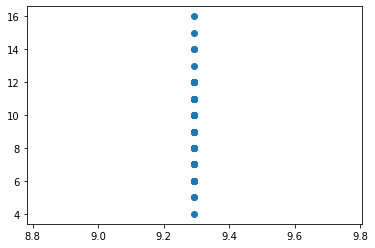

In [47]:
scatter(y_predict,dataset.sa.targets)

hmmm okay, that suggest the lasso function is totally lost, if it's predicting the same output for every target...?

Two separate questions:

 - when we run single predictor, over ALL items, it spits out the _same_ score for every single image
 - when we run LOOCV, it spits out scores almost perfectly _anticorrelated_ with the training data.
 - The correlation must come from the adjustment of the intercept, because I can't see any other reason that it is somehow perfectly obtaining the test dataset.

In [50]:
def do_regression(dataset,normalization=None,get_prediction=None,verbose=False):
    if get_prediction is None:
        get_prediction = do_Ridge
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []

    items_to_eliminate_count = np.sum(np.isnan(dataset.sa.targets))
    items_total = len(dataset.sa.targets)
    print("eliminating " + str(items_to_eliminate_count) + " of " + 
          str(items_total) + " items due to null input values.")
    
    dataset=dataset[np.isnan(dataset.sa.targets)==False]

    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
#         print(train_y)
#         print(test_y)
        predict_y, sklearn_clf = get_prediction(train_X,train_y,test_X,test_y)
        
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
        })
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, model_final =get_prediction(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,#'group_wise':group_scores,
            'model':model_final})


In [49]:
from sklearn.linear_model import Lasso
def do_Lasso(train_X,train_y,test_X,test_y):
    sklearn_regress = Lasso(alpha=5.0)
    
    sklearn_regress.fit(train_X, train_y)
    predict_train_y = sklearn_regress.predict(train_X)
    print(pd.DataFrame({
        'prediction_y':predict_train_y,
        'train_y': train_y
    }))
    predict_y = sklearn_regress.predict(test_X)
    print(predict_y,test_y,end=", ")
    return(predict_y,sklearn_regress)

In [53]:
regression_results_dict = {}
for regression_var in [
    'TESQ_E_goal_deliberation'
    #,
#     'TESQ_E_sum', 'TESQ_E_avoidance_of_temptations',
#                        'TESQ_E_goal_deliberation',
#                        'TESQ_E_goal_and_rule_setting','TESQ_E_suppression',
#                        'bf_1','SST_SSRT'
                      ]:
    print(regression_var)
    Brain_Data_CorrectStop = setup_metadata(Brain_Data_CorrectStop,regression_var)
    regression_results = do_regression(Brain_Data_CorrectStop, get_prediction = do_Lasso)
    regression_results_dict[regression_var] = regression_results
    print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
    print("---")

TESQ_E_goal_deliberation
eliminating 6 of 81 items due to null input values.
.    prediction_y  train_y
0       9.337838     11.0
1       9.337838      6.0
2       9.337838      6.0
3       9.337838     11.0
4       9.337838     14.0
..           ...      ...
69      9.337838     12.0
70      9.337838      9.0
71      9.337838      8.0
72      9.337838      6.0
73      9.337838      8.0

[74 rows x 2 columns]
[9.337838] [6.], .    prediction_y  train_y
0        9.27027      6.0
1        9.27027      6.0
2        9.27027      6.0
3        9.27027     11.0
4        9.27027     14.0
..           ...      ...
69       9.27027     12.0
70       9.27027      9.0
71       9.27027      8.0
72       9.27027      6.0
73       9.27027      8.0

[74 rows x 2 columns]
[9.27027] [11.], .    prediction_y  train_y
0       9.337838      6.0
1       9.337838     11.0
2       9.337838      6.0
3       9.337838     11.0
4       9.337838     14.0
..           ...      ...
69      9.337838     12.0
70      

[9.337838] [6.], .    prediction_y  train_y
0       9.283784      6.0
1       9.283784     11.0
2       9.283784      6.0
3       9.283784      6.0
4       9.283784     11.0
..           ...      ...
69      9.283784     12.0
70      9.283784      9.0
71      9.283784      8.0
72      9.283784      6.0
73      9.283784      8.0

[74 rows x 2 columns]
[9.283784] [10.], .    prediction_y  train_y
0       9.324325      6.0
1       9.324325     11.0
2       9.324325      6.0
3       9.324325      6.0
4       9.324325     11.0
..           ...      ...
69      9.324325     12.0
70      9.324325      9.0
71      9.324325      8.0
72      9.324325      6.0
73      9.324325      8.0

[74 rows x 2 columns]
[9.324325] [7.], .    prediction_y  train_y
0       9.256757      6.0
1       9.256757     11.0
2       9.256757      6.0
3       9.256757      6.0
4       9.256757     11.0
..           ...      ...
69      9.256757     12.0
70      9.256757      9.0
71      9.256757      8.0
72      9.25675

[9.2972975] [9.], .    prediction_y  train_y
0       9.297297      6.0
1       9.297297     11.0
2       9.297297      6.0
3       9.297297      6.0
4       9.297297     11.0
..           ...      ...
69      9.297297     12.0
70      9.297297      9.0
71      9.297297      8.0
72      9.297297      6.0
73      9.297297      8.0

[74 rows x 2 columns]
[9.2972975] [9.], .    prediction_y  train_y
0       9.310811      6.0
1       9.310811     11.0
2       9.310811      6.0
3       9.310811      6.0
4       9.310811     11.0
..           ...      ...
69      9.310811     12.0
70      9.310811      9.0
71      9.310811      8.0
72      9.310811      6.0
73      9.310811      8.0

[74 rows x 2 columns]
[9.310811] [8.], .    prediction_y  train_y
0       9.310811      6.0
1       9.310811     11.0
2       9.310811      6.0
3       9.310811      6.0
4       9.310811     11.0
..           ...      ...
69      9.310811     12.0
70      9.310811      9.0
71      9.310811      8.0
72      9.3108

[9.256757] [12.], .    prediction_y  train_y
0       9.297297      6.0
1       9.297297     11.0
2       9.297297      6.0
3       9.297297      6.0
4       9.297297     11.0
..           ...      ...
69      9.297297      8.0
70      9.297297     12.0
71      9.297297      8.0
72      9.297297      6.0
73      9.297297      8.0

[74 rows x 2 columns]
[9.2972975] [9.], .    prediction_y  train_y
0       9.310811      6.0
1       9.310811     11.0
2       9.310811      6.0
3       9.310811      6.0
4       9.310811     11.0
..           ...      ...
69      9.310811      8.0
70      9.310811     12.0
71      9.310811      9.0
72      9.310811      6.0
73      9.310811      8.0

[74 rows x 2 columns]
[9.310811] [8.], .    prediction_y  train_y
0       9.337838      6.0
1       9.337838     11.0
2       9.337838      6.0
3       9.337838      6.0
4       9.337838     11.0
..           ...      ...
69      9.337838      8.0
70      9.337838     12.0
71      9.337838      9.0
72      9.3378

That's probably it--it's probably doing some kind of intercept adjustment...

In [58]:
from sklearn.linear_model import Lasso
def do_Lasso_no_intercept(train_X,train_y,test_X,test_y):
    sklearn_regress = Lasso(alpha=5.0,fit_intercept=False)
    
    sklearn_regress.fit(train_X, train_y)
    predict_train_y = sklearn_regress.predict(train_X)
    print(pd.DataFrame({
        'prediction_y':predict_train_y,
        'train_y': train_y
    }))
    predict_y = sklearn_regress.predict(test_X)
    print(predict_y,test_y,end=", ")
    return(predict_y,sklearn_regress)

In [59]:
regression_results_dict = {}
for regression_var in [
    'TESQ_E_goal_deliberation'
    #,
#     'TESQ_E_sum', 'TESQ_E_avoidance_of_temptations',
#                        'TESQ_E_goal_deliberation',
#                        'TESQ_E_goal_and_rule_setting','TESQ_E_suppression',
#                        'bf_1','SST_SSRT'
                      ]:
    print(regression_var)
    Brain_Data_CorrectStop = setup_metadata(Brain_Data_CorrectStop,regression_var)
    regression_results = do_regression(Brain_Data_CorrectStop, get_prediction = do_Lasso_no_intercept)
    regression_results_dict[regression_var] = regression_results
    print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
    print("---")

TESQ_E_goal_deliberation
eliminating 6 of 81 items due to null input values.
.    prediction_y  train_y
0       6.131403     11.0
1       6.087667      6.0
2       4.091197      6.0
3       5.933305     11.0
4       8.954374     14.0
..           ...      ...
69      3.969534     12.0
70      6.444103      9.0
71      7.436653      8.0
72      8.938215      6.0
73      5.567523      8.0

[74 rows x 2 columns]
[1.8044276] [6.], .    prediction_y  train_y
0       2.688902      6.0
1       5.868124      6.0
2       4.163959      6.0
3       6.120960     11.0
4       8.447811     14.0
..           ...      ...
69      3.945163     12.0
70      7.032325      9.0
71      7.966966      8.0
72      8.910761      6.0
73      5.754028      8.0

[74 rows x 2 columns]
[4.7604933] [11.], .    prediction_y  train_y
0       2.211436      6.0
1       5.915698     11.0
2       4.285947      6.0
3       6.063834     11.0
4       8.776013     14.0
..           ...      ...
69      3.944636     12.0
70   

[6.088377] [6.], .    prediction_y  train_y
0       2.145828      6.0
1       5.943300     11.0
2       6.001274      6.0
3       4.198929      6.0
4       5.949630     11.0
..           ...      ...
69      4.079924     12.0
70      6.548527      9.0
71      7.574231      8.0
72      8.958401      6.0
73      5.607855      8.0

[74 rows x 2 columns]
[7.7330127] [10.], .    prediction_y  train_y
0       2.221300      6.0
1       5.928645     11.0
2       6.087255      6.0
3       4.281415      6.0
4       6.054428     11.0
..           ...      ...
69      3.953381     12.0
70      6.612775      9.0
71      7.716356      8.0
72      9.041706      6.0
73      5.684235      8.0

[74 rows x 2 columns]
[7.39762] [7.], .    prediction_y  train_y
0       2.255846      6.0
1       5.890942     11.0
2       5.985003      6.0
3       4.386548      6.0
4       6.227717     11.0
..           ...      ...
69      3.896484     12.0
70      6.492211      9.0
71      7.726896      8.0
72      9.11049

[1.7540352] [9.], .    prediction_y  train_y
0       2.226230      6.0
1       5.909592     11.0
2       6.034696      6.0
3       4.343656      6.0
4       6.097177     11.0
..           ...      ...
69      3.945625     12.0
70      6.623600      9.0
71      7.751546      8.0
72      8.870815      6.0
73      5.677010      8.0

[74 rows x 2 columns]
[7.760644] [9.], .    prediction_y  train_y
0       2.230479      6.0
1       5.869723     11.0
2       6.105092      6.0
3       4.331048      6.0
4       6.243871     11.0
..           ...      ...
69      3.853886     12.0
70      6.706920      9.0
71      7.752665      8.0
72      8.998401      6.0
73      5.599457      8.0

[74 rows x 2 columns]
[5.5418043] [8.], .    prediction_y  train_y
0       1.955796      6.0
1       6.054581     11.0
2       5.925176      6.0
3       4.423864      6.0
4       5.879585     11.0
..           ...      ...
69      3.978935     12.0
70      6.671075      9.0
71      7.670272      8.0
72      8.6720

[3.3745825] [12.], .    prediction_y  train_y
0       2.066240      6.0
1       6.102353     11.0
2       6.029785      6.0
3       4.152893      6.0
4       6.082249     11.0
..           ...      ...
69      9.801458      8.0
70      3.841960     12.0
71      7.745178      8.0
72      8.947182      6.0
73      5.686227      8.0

[74 rows x 2 columns]
[5.9944715] [9.], .    prediction_y  train_y
0       2.181494      6.0
1       5.922021     11.0
2       6.085671      6.0
3       4.269966      6.0
4       6.033901     11.0
..           ...      ...
69     10.030405      8.0
70      3.954322     12.0
71      6.634818      9.0
72      9.041983      6.0
73      5.669056      8.0

[74 rows x 2 columns]
[7.656746] [8.], .    prediction_y  train_y
0       2.290027      6.0
1       5.969409     11.0
2       6.405951      6.0
3       4.438511      6.0
4       6.267802     11.0
..           ...      ...
69      9.924473      8.0
70      3.908402     12.0
71      6.703559      9.0
72      7.494

array([-1.32185772,  0.68501129, -1.32185772, -1.32185772,  0.68501129,
        1.88913269, -0.51911012,         nan,  1.08638509, -0.51911012,
        1.08638509, -0.92048392,  1.08638509, -0.92048392, -0.51911012,
       -0.51911012, -0.11773631,  0.68501129, -0.92048392, -0.11773631,
               nan,         nan, -1.32185772,  1.48775889,  1.08638509,
       -1.32185772,  0.28363749, -0.92048392,  1.08638509, -1.72323152,
        0.68501129,  1.08638509,  0.68501129, -0.92048392, -1.32185772,
       -0.92048392, -0.92048392,  2.69188029,  1.88913269,  0.28363749,
        1.08638509,  1.08638509,  0.28363749,  1.08638509, -0.51911012,
        0.28363749, -0.51911012, -0.51911012, -0.92048392, -0.11773631,
       -0.11773631, -0.51911012, -0.51911012,  1.08638509, -0.11773631,
       -0.11773631, -0.51911012,  0.28363749, -2.12460532,         nan,
       -0.11773631, -0.51911012,  2.29050649, -0.51911012,  1.08638509,
       -0.51911012,  0.68501129,  0.28363749,  0.28363749,  0.28